<a href="https://colab.research.google.com/github/agus-fran-1998/BotTrading/blob/main/Trading_bot_24hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuración del Ambiente


In [1]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


In [2]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version



Python 3.11.11
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0


# 2. Obtención de datos

## 2.1 Precios Históricos del Bitcoin

In [3]:
def importar_base_bitcoin():
    global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia
    global media_bitcoin, algoritmo_decision, color

    end_data = datetime.now()
    start_data = end_data - timedelta(days=7)

    #Descargando datos de BTC usando Yahoo Finance
    df_bitcoin = yf.download(
       tickers= "BTC-USD",
       start=start_data.strftime("%Y-%m-%d"),
       end=end_data.strftime("%Y-%m-%d"),
       interval="5m")

    # Aplanar columnas de manera definitiva
    df_bitcoin.columns = [col[0] for col in df_bitcoin.columns]

    # Acomodar las columnas
    df_bitcoin = df_bitcoin[["Open","High","Low","Close","Volume"]]

In [4]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-01-21 00:00:00+00:00,102130.648438,102250.953125,101828.734375,101828.734375,0
2025-01-21 00:05:00+00:00,101713.226562,101832.828125,101713.226562,101773.695312,0
2025-01-21 00:10:00+00:00,101870.609375,102134.867188,101870.609375,101928.312500,0
2025-01-21 00:15:00+00:00,102235.375000,102307.664062,102235.375000,102303.093750,0
2025-01-21 00:20:00+00:00,102178.140625,102354.070312,102178.140625,102230.554688,0


In [5]:
print(df_bitcoin.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [6]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2025-01-21 00:00:00+00:00 to 2025-01-27 23:55:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2016 non-null   float64
 1   High    2016 non-null   float64
 2   Low     2016 non-null   float64
 3   Close   2016 non-null   float64
 4   Volume  2016 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.5 KB


**Renombrando las columnas**

In [7]:
# # Aplanar columnas de manera definitiva
# df_bitcoin.columns = ['_'.join(map(str, col)) if isinstance(col, tuple) else col for col in df_bitcoin.columns]

# # Verificar que las columnas sean planas
# print(df_bitcoin.columns)

# # Renombrar columnas después del aplanado
# columnas_nuevas = {
#     'Close_BTC-USD': 'Close_BTC-USD',
#     'High_BTC-USD': 'High_BTC-USD',
#     'Low_BTC-USD': 'Low_BTC-USD',
#     'Open_BTC-USD': 'Open_BTC-USD',
#     'Volume_BTC-USD': 'Volume_BTC-USD'
# }

# # Renombrar las columnas con un diccionario
# df_bitcoin.rename(columns=columnas_nuevas, inplace=True)

# # Confirmar los cambios
# print(df_bitcoin.head())

In [8]:
print(df_bitcoin)
print(df_bitcoin.index)

                                    Open           High            Low          Close  Volume
Datetime                                                                                     
2025-01-21 00:00:00+00:00  102130.648438  102250.953125  101828.734375  101828.734375       0
2025-01-21 00:05:00+00:00  101713.226562  101832.828125  101713.226562  101773.695312       0
2025-01-21 00:10:00+00:00  101870.609375  102134.867188  101870.609375  101928.312500       0
2025-01-21 00:15:00+00:00  102235.375000  102307.664062  102235.375000  102303.093750       0
2025-01-21 00:20:00+00:00  102178.140625  102354.070312  102178.140625  102230.554688       0
...                                  ...            ...            ...            ...     ...
2025-01-27 23:35:00+00:00  101796.750000  101958.125000  101796.750000  101854.351562       0
2025-01-27 23:40:00+00:00  101818.851562  101929.921875  101818.851562  101929.921875       0
2025-01-27 23:45:00+00:00  101809.132812  101834.492188  101

In [9]:
type(df_bitcoin) # Muestra que es un Dataframe

pandas.core.frame.DataFrame

## 2.2 Indicadores de Tendencias

# ATENCION
# Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona
# revisen la estructura actualizada del HTML.

In [10]:
# VERSION 1


# def extraer_tendencias():
#     """
#     Extrae tendencias y toma decisiones de trading basadas en el análisis de precios de Bitcoin.

#     Esta función utiliza la biblioteca yfinance para obtener datos históricos de Bitcoin y BeautifulSoup
#     para scrapear el precio actual y la variación de precio de CoinMarketCap. Luego, calcula la media del
#     precio de cierre y establece una tendencia simple basada en la comparación de precios. Finalmente,
#     define un algoritmo de decisión basado en la tendencia y el precio actual.

#     Variables globales:
#     df_bitcoin (pandas.DataFrame): DataFrame que contiene los datos históricos de Bitcoin.
#     precio_actual (float): Precio actual de Bitcoin.
#     tendencia (str): Tendencia del mercado ("Alcista" o "Bajista").
#     media_bitcoin (float): Media del precio de cierre de Bitcoin.
#     algoritmo_decision (str): Decisión del algoritmo ("Comprar", "Vender" o "Esperar").
#     """


#     global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
#     from bs4 import BeautifulSoup
#     import requests
# headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'}

# # URL de la página de CoinMarketCap
# url = "https://coinmarketcap.com/"
# # Realizar una solicitud GET a la URL
# response = requests.get(url, headers=headers)
# # Parsear el contenido de la página con BeautifulSoup
# soup = BeautifulSoup(response.content, features = 'lxml')


# # Buscar el elemento que contiene el precio actual del Bitcoin en USD
# bitcoin_price_element = soup.find('div', {'class': ['sc-b3fc6b7-0 dzgUIj rise','sc-b3fc6b7-0 dzgUIj','sc-b3fc6b7-0 dzgUIj fall']})
# bitcoin_1h_change_element = soup.find('span', {'class': ['sc-a59753b0-0 ivvJzO']})


# span_element = bitcoin_price_element.find('span')
# span_element2 = bitcoin_1h_change_element.find('span')

# variacion = span_element2.get('class')

# precio = span_element.text.strip()
# precio_actual = float(precio.replace('$', '').replace(',', ''))

# variacion = str(variacion)

# # Llama a la función para extraer las tendencias
# extraer_tendencias()

# if variacion == "['icon-Caret-up']":
#     tendencia = "Alcista"
# elif variacion == "['icon-Caret-down']":
#     tendencia = "Bajista"
# else:
#     tendencia = ""


# # Definir un algoritmo de decisión
#     if precio_actual > media_bitcoin and tendencia == "Bajista":
#         algoritmo_decision = "Comprar"
#     elif precio_actual < media_bitcoin and tendencia == "Alcista":
#         algoritmo_decision = "Vender"
#     else:
#         algoritmo_decision = "Esperar"

# # Imprime las variables globales
# print("********************")
# print("Precio Actual:", precio_actual)
# print("Tendencia:", tendencia)
# print("Media Bitcoin:", media_bitcoin)
# print("Algoritmo de Decisión:", algoritmo_decision)
# print("********************")



# VERSION 2
def extraer_tendencias():
    global precio_actual, tendencia, color

    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
    url = 'https://coinmarketcap.com/currencies/bitcoin/'

    try:
        # Realizar la solicitud con los headers para evitar ser bloqueado
        respuesta = requests.get(url, headers=headers)
        respuesta.raise_for_status()
        s = BeautifulSoup(respuesta.content, 'html.parser')

        # 1. Extraer el precio actual del BTC
        precio_tag = s.find("span", {"data-test": "text-cdp-price-display"})

        if precio_tag:        #  class : [sc-65e7f566-0 esyGGG data-test="text-cdp-price-display"
            precio_actual = float(precio_tag.getText().replace('$', '').replace(',', ''))
        else:
            precio_actual = None

        # 2. Extraer la tendencia del precio (alta o baja)
        tendencia_tag = s.find("p", {"color": True, "data-change": True})
        if tendencia_tag:
            color = tendencia_tag['color']
            if color == "green":
                tendencia = "alta"
            elif color == "red":
                tendencia = "baja"
            else:
                tendencia = "estable"
        else:
            tendencia = None
            color = None

        return precio_actual, tendencia

    except Exception as e:
        print("Error al extraer datos:", e)


In [11]:
precio_actual, tendencia = extraer_tendencias()

In [12]:
extraer_tendencias()
print(f"Precio actual de Bitcoin: {precio_actual}")
print(f"Tendencia: {tendencia}")


Precio actual de Bitcoin: 102742.56
Tendencia: alta


# 3. Limpieza de datos

**Visualizacion previa de los datos**

In [13]:
type(df_bitcoin)

pandas.core.frame.DataFrame

In [14]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2025-01-21 00:00:00+00:00 to 2025-01-27 23:55:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2016 non-null   float64
 1   High    2016 non-null   float64
 2   Low     2016 non-null   float64
 3   Close   2016 non-null   float64
 4   Volume  2016 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 94.5 KB


In [15]:
df_bitcoin.describe()

,Open,High,Low,Close,Volume
count,2016.000000,2016.000000,2016.000000,2016.000000,2.016000e+03
mean,103840.459480,103902.404452,103778.306199,103843.428052,7.408703e+07
std,1878.985753,1865.654626,1890.044163,1876.191559,1.746970e+08
min,97906.976562,98260.828125,97906.976562,98104.703125,0.000000e+00
25%,102485.367188,102569.095703,102408.955078,102527.365234,0.000000e+00
50%,104571.109375,104611.187500,104523.703125,104566.699219,0.000000e+00
75%,105053.214844,105087.197266,105008.189453,105052.349609,7.318323e+07
max,107145.828125,107156.882812,107023.546875,107127.554688,2.702049e+09


In [17]:
def limpieza_datos():
    # Definición de variables globales
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin

    # Reiniciar los indices
    #df_bitcoin.reset_index(inplace=True)

    # Guardar el número inicial de registros
    registros_iniciales = len(df_bitcoin)

    # Crear una copia del DataFrame original
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminar registros con índice duplicado, manteniendo solo la primera aparición
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Rellenar valores nulos en la columna 'close' con el último valor no nulo disponible
    df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)

    # Eliminar filas donde el valor en la columna 'volumen' sea menor o igual a cero
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Calcular los cuartiles y el rango intercuartílico (IQR) para la columna 'close'
    q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Eliminar registros cuyo valor en la columna 'close' esté fuera de los límites definidos por el IQR
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= limite_inferior)
    & (df_bitcoin_limpio['Close'] <= limite_superior)]

    # Calcular el precio promedio del BTK usando la columna 'close'
    media_bitcoin = df_bitcoin_limpio['Close'].mean().round(4)

    # Guardar el número de registros después del proceso
    registros_finales = len(df_bitcoin_limpio)

    # Calcular la cantidad de registros eliminados
    registros_eliminados = registros_iniciales - registros_finales

    return {
        'registros_iniciales': registros_iniciales,
        'registros_finales': registros_finales,
        'registros_eliminados': registros_eliminados,
        'media_bitcoin': media_bitcoin
    }

limpieza_datos()

<ipython-input-17-74427b5a4812>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)
<ipython-input-17-74427b5a4812>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)


{'registros_iniciales': 2016,
 'registros_finales': 794,
 'registros_eliminados': 1222,
 'media_bitcoin': 102707.4728}

In [18]:
#Muestra informaciones de la base tratada
print(df_bitcoin_limpio.info())
df_bitcoin_limpio.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2025-01-21 01:05:00+00:00 to 2025-01-27 22:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    794 non-null    float64
 1   High    794 non-null    float64
 2   Low     794 non-null    float64
 3   Close   794 non-null    float64
 4   Volume  794 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 37.2 KB
None


,Open,High,Low,Close,Volume
count,794.0,794.0,794.0,794.0,7.940000e+02
mean,102699.0,102787.0,102613.0,102707.0,1.881101e+08
std,2221.0,2221.0,2218.0,2220.0,2.367962e+08
min,97907.0,98261.0,97907.0,98105.0,4.096000e+03
25%,101240.0,101326.0,101151.0,101249.0,4.378624e+07
50%,102530.0,102588.0,102468.0,102554.0,1.165599e+08
75%,104680.0,104740.0,104589.0,104659.0,2.424033e+08
max,107146.0,107157.0,107024.0,107128.0,2.702049e+09


## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [19]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2025-01-21 00:00:00+00:00 to 2025-01-27 23:55:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2016 non-null   float64
 1   High    2016 non-null   float64
 2   Low     2016 non-null   float64
 3   Close   2016 non-null   float64
 4   Volume  2016 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 159.0 KB
None


,Open,High,Low,Close,Volume
count,2016.0,2016.0,2016.0,2016.0,2.016000e+03
mean,103840.0,103902.0,103778.0,103843.0,7.408703e+07
std,1879.0,1866.0,1890.0,1876.0,1.746970e+08
min,97907.0,98261.0,97907.0,98105.0,0.000000e+00
25%,102485.0,102569.0,102409.0,102527.0,0.000000e+00
50%,104571.0,104611.0,104524.0,104567.0,0.000000e+00
75%,105053.0,105087.0,105008.0,105052.0,7.318323e+07
max,107146.0,107157.0,107024.0,107128.0,2.702049e+09


## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

<Axes: >

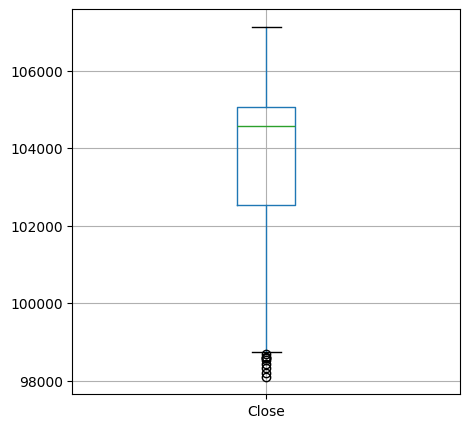

In [21]:
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close'])

## 3.3 Función para la limpieza de los datos de Bitcoin

## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

<ipython-input-17-74427b5a4812>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)
<ipython-input-17-74427b5a4812>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)


<Axes: >

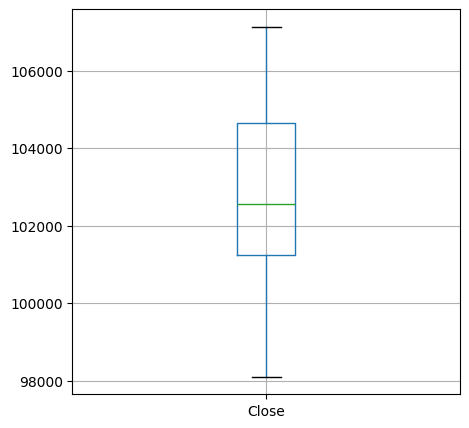

In [22]:
limpieza_datos()
#Muestra el Boxplot de la base limpia

df_bitcoin_limpio.boxplot(['Close'])

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

In [ ]:
#@title Gráfico de distribución del Precio de Cierre antes y después de la limpieza { display-mode: "form" }
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10, 6))
plt.hist(df_bitcoin['Close_BTC-USD'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close_BTC-USD'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias moviles

In [ ]:
df_bitcoin_limpio.info()

In [23]:
def calcular_sma():
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (10 periodos)
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (50 periodos)
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()

calcular_sma()

In [24]:
print(df_bitcoin_limpio.head())

                                    Open           High            Low          Close     Volume  SMA_corto  SMA_largo
Datetime                                                                                                              
2025-01-21 01:05:00+00:00  101755.773438  101847.531250  101574.500000  101720.632812   85819392        NaN        NaN
2025-01-21 01:30:00+00:00  100351.132812  100548.414062  100103.953125  100548.414062   94003200        NaN        NaN
2025-01-21 01:35:00+00:00  100748.750000  101156.312500  100748.750000  101107.070312  653090816        NaN        NaN
2025-01-21 01:40:00+00:00  101003.835938  101214.601562  100917.257812  101095.460938  268984320        NaN        NaN
2025-01-21 01:45:00+00:00  101181.781250  101268.937500  101063.828125  101063.828125  182730752        NaN        NaN


In [25]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2025-01-21 01:05:00+00:00 to 2025-01-27 22:50:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       794 non-null    float64
 1   High       794 non-null    float64
 2   Low        794 non-null    float64
 3   Close      794 non-null    float64
 4   Volume     794 non-null    int64  
 5   SMA_corto  785 non-null    float64
 6   SMA_largo  745 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.6 KB


## 4.2 Evaluar datos y tomar decision

In [33]:
# # Función para tomar decisiones basadas en SMA y tendencia del mercado
# def tomar_decisiones(df_bitcoin_limpio):
#     global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

#     # Obtener los valores más recientes de SMA corta y SMA larga
#     SMA_corto = df_bitcoin_limpio['SMA_corto'].iloc[-1]
#     SMA_largo = df_bitcoin_limpio['SMA_largo'].iloc[-1]

#     # Decidir según las condiciones definidas
#     if SMA_corto > SMA_largo and tendencia == "Alta":
#         algoritmo_decision = "Comprar"
#         color = "#00FF00"  # Color verde para la compra
#     elif SMA_corto < SMA_largo and tendencia == "Baja":
#         algoritmo_decision = "Vender"
#         color = "#FF0000"  # Color rojo para la venta
#     else:
#         algoritmo_decision = "Mantener"
#         color = "#000000"  # Color negro para mantener

#     # Imprimir los resultados
#     print(f"Precio actual: {precio_actual}")
#     print(f"SMA Corta: {SMA_corto}")
#     print(f"SMA Larga: {SMA_largo}")
#     print(f"Tendencia del mercado: {tendencia}")
#     print(f"Decisión del algoritmo: {algoritmo_decision}")
#     print(f"Color de la señal: {color}")

# tomar_decisiones(df_bitcoin_limpio)



# Función para tomar decisiones basadas en SMA y tendencia del mercado
def tomar_decisiones():
    global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    # Obtener los valores más recientes de SMA_corto y SMA_largo
    SMA_corto = df_bitcoin_limpio['SMA_corto'].iloc[-1]
    SMA_largo = df_bitcoin_limpio['SMA_largo'].iloc[-1]

    # Decidir según las condiciones definidas
    if SMA_corto > SMA_largo and tendencia == "Alta":
        algoritmo_decision = "Comprar"
        color = "#00FF00"  # Color verde para la compra
    elif SMA_corto < SMA_largo and tendencia == "Baja":
        algoritmo_decision = "Vender"
        color = "#FF0000"  # Color rojo para la venta
    else:
        algoritmo_decision = "Mantener"
        color = "#000000"  # Color negro para mantener

    # Imprimir los resultados
    print(f"Precio actual: {precio_actual}")
    print(f"SMA Corto: {SMA_corto}")
    print(f"SMA Largo: {SMA_largo}")
    print(f"Tendencia del mercado: {tendencia}")
    print(f"Decisión del algoritmo: {algoritmo_decision}")
    print(f"Color de la señal: {color}")
tomar_decisiones()

Precio actual: 102786.97
SMA Corto: 101560.9625
SMA Largo: 100588.5803125
Tendencia del mercado: alta
Decisión del algoritmo: Mantener
Color de la señal: #000000


# ATENCION
# Recuerden que la tendencia de una hora puede cambiar rápidamente.
# Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

In [34]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2025-01-21 01:05:00+00:00 to 2025-01-27 22:50:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       794 non-null    float64
 1   High       794 non-null    float64
 2   Low        794 non-null    float64
 3   Close      794 non-null    float64
 4   Volume     794 non-null    int64  
 5   SMA_corto  785 non-null    float64
 6   SMA_largo  745 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.6 KB


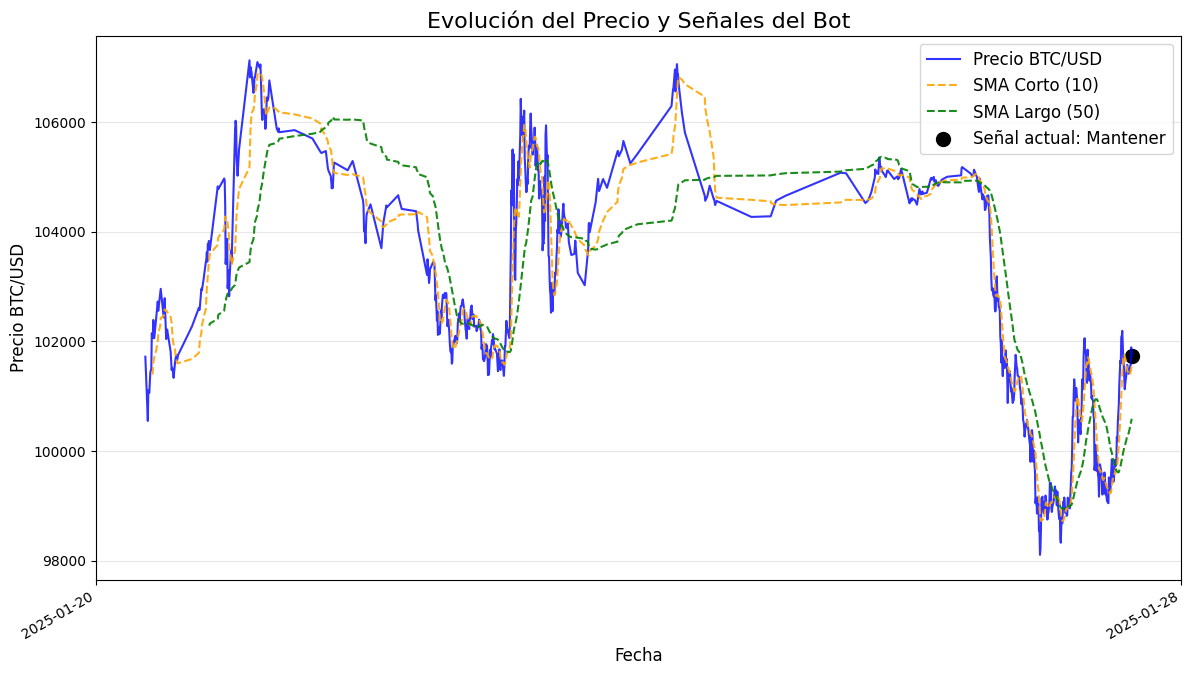

In [35]:
import matplotlib.dates as mdates

def new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color):
    """
    Genera un gráfico con la evolución del precio de la moneda, medias móviles,
    y las señales de compra o venta más recientes.

    Args:
        df_bitcoin_limpio (DataFrame): DataFrame con las columnas 'Close_BTC-USD', 'SMA_corto', 'SMA_largo'.
        algoritmo_decision (str): Decisión del bot ("Comprar", "Vender" o "Mantener").
        color (str): Color de la señal de decisión actual.
    """

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(14, 8))

    # Graficar el precio de cierre
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close'], label='Precio BTC/USD', color='blue', alpha=0.8)

    # Graficar las medias móviles
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], label='SMA Corto (10)', color='orange', linestyle='--', alpha=0.9)
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], label='SMA Largo (50)', color='green', linestyle='--', alpha=0.9)

    # Agregar la señal de compra o venta más reciente
    ultima_senal = df_bitcoin_limpio.iloc[-1]
    plt.scatter(ultima_senal.name, ultima_senal['Close'], color=color, s=100, label=f'Señal actual: {algoritmo_decision}', edgecolors='k')

    # Formato del eje X (fechas)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

    # Configurar título y etiquetas
    plt.title('Evolución del Precio y Señales del Bot', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio BTC/USD', fontsize=12)

    # Agregar leyenda
    plt.legend(fontsize=12)

    # Mostrar el gráfico
    plt.grid(alpha=0.3)
    plt.show()

new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color)

# 6. Ciclo

In [36]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2025-01-21 01:05:00+00:00 to 2025-01-27 22:50:00+00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       794 non-null    float64
 1   High       794 non-null    float64
 2   Low        794 non-null    float64
 3   Close      794 non-null    float64
 4   Volume     794 non-null    int64  
 5   SMA_corto  785 non-null    float64
 6   SMA_largo  745 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.6 KB


[*********************100%***********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_corto', 'SMA_largo'], dtype='object')
Iniciando ciclo de análisis...
Precio actual: 102729.49
SMA Corto: 101560.9625
SMA Largo: 100588.5803125
Tendencia del mercado: alta
Decisión del algoritmo: Mantener
Color de la señal: #000000



<ipython-input-17-74427b5a4812>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)
<ipython-input-17-74427b5a4812>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)


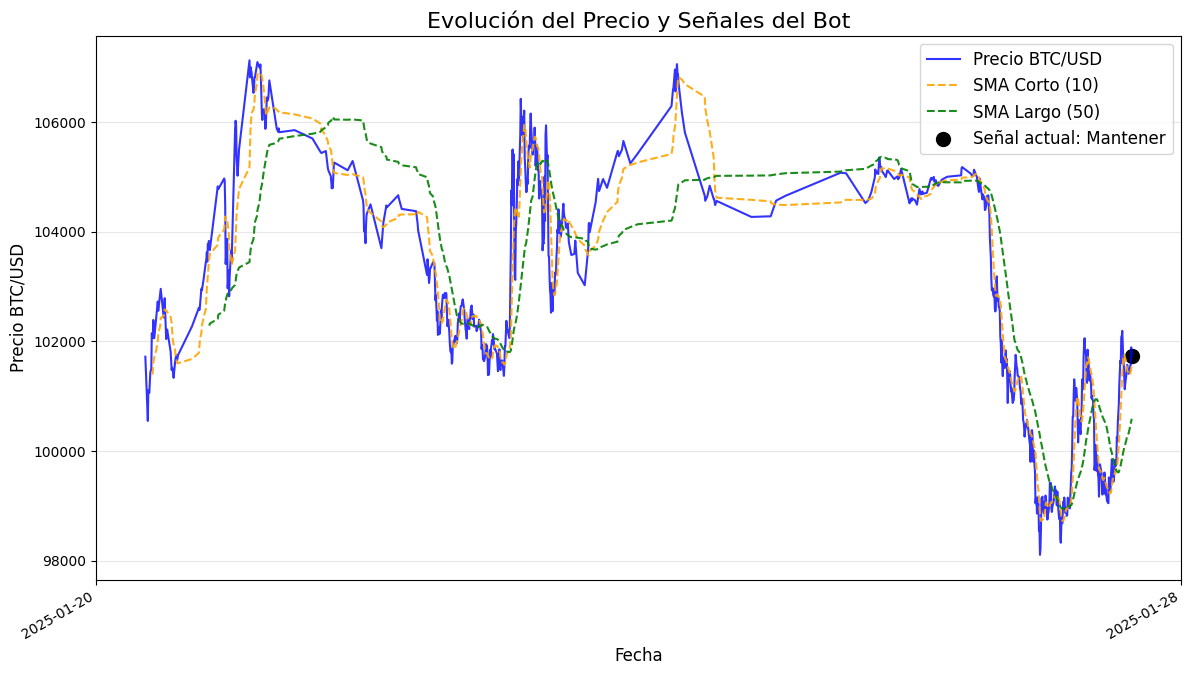

Esperando 5 minutos antes de la siguiente decisión...


KeyboardInterrupt: 

In [37]:
# Verificar las columnas
print(df_bitcoin_limpio.columns)

# Iniciar el bucle
while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma()

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones()

    # Paso 4: Graficar las tendencias y señales
    new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color)

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(300)
